# Problem
Using the MNIST dataset, create a deep learning model to classify the images containing numbers. Use batch normalization and save the model using model checkpoints.

# dataset 
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples.

site: http://yann.lecun.com/exdb/mnist/

Links to download the dataset
http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

In [1]:
#python mnist pacakage to download 
#   the images as rows of 28x28 byte block for each image
#   the labels as rows of integers

!pip3 install mnist

In [2]:
import mnist as MNIST
import numpy as np

train_images = MNIST.train_images()
train_labels = MNIST.train_labels()
test_images = MNIST.test_images()
test_labels = MNIST.test_labels()

print(len(train_images), len(test_images))

60000 10000


# Approach
The images contain digits from 0 to 9. The task is to classify a given image with these 10 labels. Its a multinominal classification problem. 

The input layer will consists of neurons proportional to the number of features, which is 28x28 pixel data i.e. 784 where each pixel is a feature.

We can use softmax as activation function in output layer which can predict the probability of a given digit. The layer will have 10 neurons each classifying a label 0 - 9.

Based on this [paper](https://ieeexplore.ieee.org/document/9252936), we will carry out the PCA (accounting for 60-70% cumulative variance) followed by k-means to estimate the hidden layers & number of neuron units. 

In [10]:
#concatenate both train and test as the source of data is different
#   we need a mix of both across training and tests
X = np.concatenate((train_images, test_images), axis=0)
Y = np.concatenate((train_labels, test_labels), axis=0)

print("X size", X.shape, "Y size", Y.shape)

#reshape the 2d image array to 1d to match the input dimension of NN
X_flat = X.reshape(70000, 28*28)

print("X size", X_flat.shape, "Y size", Y.shape)

X size (70000, 28, 28) Y size (70000,)
X size (70000, 784) Y size (70000,)


In [5]:

import numpy as np
import pandas as pd

from sklearn.model_selection import ParameterGrid
from sklearn.manifold import TSNE
from sklearn.base import clone
from sklearn.metrics import silhouette_score

class ClusterGridSearch:
    def __init__(self, estimator, param_grid, scorer=silhouette_score, positive=1):
        self.param_grid = param_grid
        self.base_estimator = estimator
        self.scorer = scorer
        self.positive = positive
        self.tsne_z = None
        
    def fit(self, X):
        best_estimator = self.base_estimator
        best_score = np.NaN
        best_params = {}
        
        params = ParameterGrid(self.param_grid)
        results = {'score': []}
        
        for param in params:
            print("running ClusterGridSearch for ", param, "on", X.shape)
            
            estimator = clone(self.base_estimator)
            estimator = estimator.set_params(**clone(param, safe=False))
            estimator = estimator.fit(X)
            
            score = self.scorer(X, estimator.labels_)
            for key in param:
                if not key in results.keys():
                    results[key] = []
                results[key].append(param[key])
            results['score'].append(score)
            
            if best_score is np.NaN:
                best_score = score
                best_estimator = estimator
                best_params = param.copy()
            elif self.positive*score > self.positive*best_score:
                best_score = score
                best_estimator = estimator
                best_params = param.copy()
            
        self.best_estimator_ = best_estimator
        self.best_score_ = best_score
        self.best_params_ = best_params
        self.results_ = results
            
        return self

    def plot(self, axis):
        axis.plot(self.results_['n_clusters'], self.results_['score'], color='k')
        axis.grid(color='grey', linestyle='--', linewidth=0.2)
        axis.set_title(self.scorer.__name__)
        axis.set_xlabel('#Clusters', color='b')
        axis.axvline(x=self.best_params_['n_clusters'], ymin=0, linewidth=2, color='r', linestyle='--')
        return self
    
    def scatter(self, X, axis):
        axis.scatter(X[:,0], X[:,1],c=self.best_estimator_.labels_);
        axis.grid(True)
        return self
    
    def tsne_plot(self, X, axis):
        tsne = TSNE(n_components=2, verbose=0, random_state=123)
        if self.tsne_z is None:
            self.tsne_z = tsne.fit_transform(pd.DataFrame(X))
        axis.scatter(self.tsne_z[:,0], self.tsne_z[:,1],c=self.best_estimator_.labels_)
        axis.grid(True)


In [6]:


import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

class HiddenLayerEstimator:
    def __init__(self, num_of_labels=2, verbose=0):
        self.num_of_labels = num_of_labels
        self.verbose = verbose
        return

    def compute_targets(self, X):
        pca_obj = PCA().fit(X)
        cum_var = 0
        
        target_n_components = 0
        target_cum_var = 40
        if self.num_of_labels > 2:
            target_cum_var = 60
            
        for comp in range(0, pca_obj.n_components_):
            target_n_components = target_n_components + 1
            cum_var = cum_var + pca_obj.explained_variance_ratio_[comp]
            
            if self.verbose > 9:
                print(
                    f"PCA_{comp}", 
                    round(pca_obj.explained_variance_ratio_[comp]*100), 
                    round(cum_var*100))
            
            if cum_var > target_cum_var:
                break;
        
        self.target_n_components = target_n_components
        self.target_cum_var = cum_var
        
        return pca_obj, target_n_components
    
    def compute_clusters(self, X):
        params_grid = {'n_clusters': range(2, 20), 'n_init': ['auto']}
        grid_search = ClusterGridSearch(KMeans(), params_grid, scorer=silhouette_score)
        grid_search.fit(X)
        
        return (grid_search, grid_search.best_params_['n_clusters'])
        
    
    def fit(self, X):
        (pca_obj, target_n_components) = self.compute_targets(X)
        
        layers = []
        
        
        X_new = pca_obj.transform(X)
        for nlayer in range(0, target_n_components):
            PC_X = X_new[:, [nlayer]]
            (grid_search, n_clusters) = self.compute_clusters(PC_X)
            
            layers.append({
                'n_neurons': n_clusters, 
                'variance': pca_obj.explained_variance_ratio_[nlayer]
            })
            
            if self.verbose > 0:
                print({
                    'layer': nlayer,
                    'n_neurons': n_clusters, 
                    'variance': pca_obj.explained_variance_ratio_[nlayer]
                })
        
        layers.reverse()
        
        cum_var_curr = 0
        for l in layers:
            cum_var_curr = cum_var_curr + l["variance"]
            l["cum_variance"] = cum_var_curr
        
        
        self.layers_ = layers
        return self

In [14]:

import numpy as np


random_indices = np.random.choice(X_flat.shape[0], 
                                  size=int(X_flat.shape[0]*0.1), 
                                  replace=False)
X_flat_sample = X_flat[random_indices, :]
X_flat_scaler = MinMaxScaler((0,1))
X_flat_sample_scaled = X_flat_scaler.fit_transform(X_flat_sample)

#hls = HiddenLayerEstimator(num_of_labels=10, verbose=1).fit(X_flat_sample_scaled)
#hls.layers_

In [15]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Train Test Split
X_train,X_test,Y_train,Y_test = train_test_split(
    X,Y,test_size=0.25,
    shuffle=True,
    random_state=21)

# Scaling the input features
#X_scaler = MinMaxScaler((0,1))
#X_train_scaled = X_scaler.fit_transform(X_train)
#X_test_scaled = X_scaler.transform(X_test)
X_train_scaled = X_train/255
X_test_scaled = X_test/255

print("X shape", X_train_scaled.shape, 
      "X min", X_train_scaled.min(), 
      "X max", X_train_scaled.max())

X shape (52500, 28, 28) X min 0.0 X max 1.0


Number of hidden layers to accomodate 60% variance as per the article needs 15 layers with 2 neurons in each layer. Instead if will start with 2 hidden layers with 15 neurons in each layer.

i/p features = 784, o/p labels = 10, hidden layers = 2 (1x15, 1x15)

In [ ]:
!pip3 install tensorflow
!pip3 install keras

In [159]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow

model = tensorflow.keras.models.Sequential()

#input layer
model.add(tensorflow.keras.layers.Flatten(input_shape=[28, 28], name="inputLayer"))

          
#batch normalization
model.add(tensorflow.keras.layers.BatchNormalization(momentum=0.9, epsilon=0.001))

#hidden layer 1
model.add(
    tensorflow.keras.layers.Dense(
        units=300, activation='leaky_relu', 
        kernel_regularizer=tensorflow.keras.regularizers.L2(0.01))
    )

#batch normalization
model.add(tensorflow.keras.layers.BatchNormalization(momentum=0.9, epsilon=0.001))

#hidden layer 2
model.add(
    tensorflow.keras.layers.Dense(
        units=100, activation='leaky_relu', 
        kernel_regularizer=tensorflow.keras.regularizers.L2(0.01))
    )

#batch normalization
model.add(tensorflow.keras.layers.BatchNormalization(momentum=0.9, epsilon=0.001))

#output layer
model.add(
    tensorflow.keras.layers.Dense(
        units=10, activation='softmax',
        kernel_regularizer=tensorflow.keras.regularizers.L2(0.01))
)

#optimizer
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
sgd_optimizer = tensorflow.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    optimizer=sgd_optimizer, 
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(), 
    metrics='accuracy')

model.summary()

# Create a callback that saves the model's weights
checkpoint_path = "./.ckpts/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=0)

history = model.fit(
    X_train_scaled,Y_train,batch_size=32,
    validation_split=0.3,callbacks=[cp_callback],
    epochs=5,verbose=0)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 300)               235500    
                                                                 
 batch_normalization_26 (Ba  (None, 300)               1200      
 tchNormalization)                                               
                                                                 
 dense_40 (Dense)            (None, 100)               30100     
                                                                 
 batch_normalization_27 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_41 (Dense)            (None, 10)                1010      
                                                                 
Total params: 268210 (1.02 MB)
Trainable params: 2674

In [138]:
!pip3 install matplotlib

In [1]:
import matplotlib.pyplot as plt


# Plotting the learning curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Learning Curve')
plt.legend(['Training Loss','Valdiation Loss'])
plt.show()

# Plotting the accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Learning Curve')
plt.legend(['Training Accuracy','Valdiation Accuracy'])
plt.show()


NameError: name 'history' is not defined

Train: 0.953, Test: 0.947


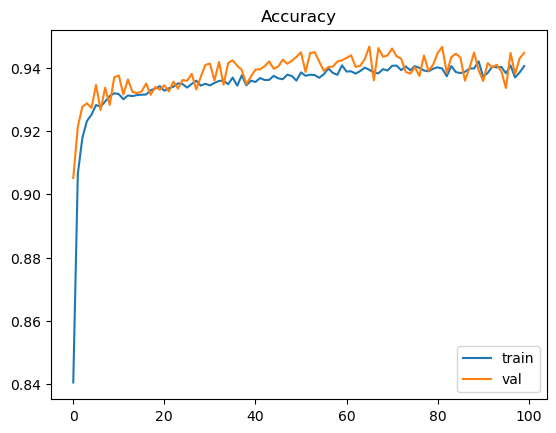

In [144]:
# evaluate the model
_, test_acc = model.evaluate(X_test_scaled, Y_test, verbose=0)
print('Test: %.3f' % (test_acc))
